dataset: Stanford Sentiment Treebank
pre train model: RoBERTa - roberta-base or ALBERT - albert-base-v2
evaluation criteria: accuracy, f1-score, cross-entropy loss, precision & recall, and confusion matrix 


[2.0 points] Give an overview of the dataset you have chosen to use.

What is the classification task? What business case does it solve? Is this multi-task? Explain.
What is the feature data? Who collected the data? Why? When? Is the data multi-modal?
What evaluation criteria will you be using and why? Why does this support the business case?

The dataset we want to use is the Stanford Sentiment Treebank form link. (https://research.aimultiple.com/sentiment-analysis-dataset/#stanford-sentiment-treebank, https://nlp.stanford.edu/sentiment/index.html ) This is a many to one dataset and this dataset contains about 10,000 reviews on the movies with a sentiment score from 1 to 25. The most positive is 25 and the most negative is 1. This dataset is used to classify the sentiment of movie review into positive, negative, or neutral categories based on the sentiment score.


The business cases that this dataset can solve are analyzing the customer’s feedback, monitoring the social media reaction after the movie release, etc. For the film industry, they can use the model trained with this dataset to monitor the reviews of their released movies on social media and adjust their marketing strategies in a timely manner, or movie rating platforms such as RottenTomatoes can have more optimized rating strategies.


This is a single task classification, the main goal of this dataset is to predict the sentiment of a given sentence. In the dataset multiple words are sequences that contribute to a single sentiment label 1 to 25. 


The feature data of this dataset are the text data collection from the movie reviews. The labels of this dataset are the sentiment scores from 1 to 25. In this dataset each phrase is assigned a sentiment score. This dataset was collected by the researchers form stanford university in 2013. The reason why they collect this dataset is because the traditional sentiment analysis models classify the full sentence, but human language is usually ambiguous. If we continue to distinguish it based on a whole sentence, we will ignore the influence of some words. For example, if a movie review is "not bad" or "not too bad", the traditional model will ignore the influence of the preceding "not" or "not too" and directly classify the review as bad, a negative score. In fact, "not bad" is more like a neutral score. That is why they collect this dataset and provide phrase level sentiment labels, and they use the tree based structure to capture the compositional sentiment. They think this can help the machine learning model have a better understanding in the complex sentence structure. 


This data is not a multi-model, it is unimodal. Because only text data in this data set. 


This dataset can help solve the business case like analyzing customer feedback and monitoring social media reaction. So we want to use accuracy, f1-score, cross-entropy loss, precision & recall, and confusion matrix as the evaluation criteria. Here are the reasons: the accuracy used to measure the proportion of correctly classified reviews, this for the general measurement for the model. The F1 Score is the balance of precision and recall. For the sentiment classification tasks, to eliminate the effect of imbalanced data, the f1 score is more informative than accuracy. The cross-entropy loss helps optimize the model confidence in the correct classifications. Is used for measuring the divergence between predicted probability distribution and actual labels. The precision & recall can ensure the positive sentiment predictions are truly positive and also ensure the model identifies the relevant sentiment example as possible. The confuse matrix provides the insight of misclassification patterns, which can help as to know which sentiment classes are confused with each other. 


For our business case like monitor the social media reaction or movies review rating. A high f1 score can ensure the model correctly classifies the sentiment. The precision & recall help as avoiding the false signal when tracking audience sentiment across social media. The improvement on the accuracy cna help the review platforms reducing the bias in their score. 

[2.0 points] Describe the foundational model that you will be using to transfer learn from. What task(s) was this foundational model trained upon? Explain if the new task is within the same domain, across domains, etc. 


The foundational model we want to use to transfer learning form is ALBERT-Base-v2. This model is a variant to BERT that can improve the efficiency while keeping the performance at the same level. This model was introduced by Google research in 2019, and is design yo solve the limitation of BERT when performing the task like parameter reduction techniques. The albert-base-v2 model has 12 repeating layers, 128 embedding, 768-hidden, 12-heads, 11M parameters. https://huggingface.co/transformers/v3.3.1/pretrained_models.html, https://github.com/google-research/ALBERT The ALBERT was trained using for self-supervised learning on the large task corpora. It was pre trained to perform the task like: masked language modeling, which is the model randomly masks some words, makes it invisible and learns to predict the missing words. Also trained for sentence order prediction, it was trained to detect if the two sentences were swapped with each other. The new task sentiment classification is within the same domain as the pre-training tasks, because both tasks need the model to understand the structure of the sentences. The ALBERT already understands the contextual word relationships, and phrase structure, so we think is can be fine tuned efficiently for the sentiment classification. 

[1.0 points] Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

In [1]:
import re
import pandas as pd
import numpy as np
from nltk.tree import Tree

# Function to parse the tree structure and extract phrases with sentiment scores
def parse_trees_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read().strip()
    
    # Split into individual trees (sentences)
    tree_strings = data.split('\n')
    
    all_phrases = []
    
    for tree_str in tree_strings:
        try:
            # Parse the tree
            tree = Tree.fromstring(tree_str)
            
            # Extract phrases and scores
            phrases_with_scores = extract_phrases_and_scores(tree)
            all_phrases.extend(phrases_with_scores)
        except Exception as e:
            print(f"Error parsing tree: {e}")
            continue
    
    df = pd.DataFrame(all_phrases, columns=['phrase', 'sentiment_score'])
    return df

# Function to recursively extract phrases and their sentiment scores
def extract_phrases_and_scores(tree):
    if not isinstance(tree, Tree):
        return []
    
    results = []
    
    # Get the label
    label = int(tree.label())
    
    # Get the phrase
    phrase = ' '.join(tree.leaves())
    
    # Add phrase and its score
    if phrase:
        results.append((phrase, label))
    
    # process each subtree
    for subtree in tree:
        if isinstance(subtree, Tree):
            results.extend(extract_phrases_and_scores(subtree))
    
    return results

# Parse the dev.txt file
dataset_path = './Dataset/dev.txt'
dev_df = parse_trees_from_file(dataset_path)

# Display statistics
print(f"Total extracted phrases: {len(dev_df)}")
print("\nSentiment score distribution:")
print(dev_df['sentiment_score'].value_counts().sort_index())

# Save the dataset
dev_df.to_csv('./Dataset/parsed_dev_dataset.csv', index=False)
print("\nDataset saved to './Dataset/parsed_dev_dataset.csv'")

# Sample of phrases with different sentiment scores
print("\nSample phrases by sentiment score:")
for score in range(5):  # 0 to 4
    sample = dev_df[dev_df['sentiment_score'] == score].sample(min(3, len(dev_df[dev_df['sentiment_score'] == score])))
    print(f"\nScore {score}:")
    for phrase in sample['phrase']:
        print(f"  - \"{phrase}\"")

Total extracted phrases: 41447

Sentiment score distribution:
sentiment_score
0     1070
1     4613
2    28305
3     5781
4     1678
Name: count, dtype: int64

Dataset saved to './Dataset/parsed_dev_dataset.csv'

Sample phrases by sentiment score:

Score 0:
  - "Sticky sweet sentimentality , clumsy plotting and a rosily myopic view of life in the WWII-era Mississippi Delta undermine this adaptation ."
  - "drab and sordid"
  - "dull"

Score 1:
  - "could not find a buyer to play it on the tube"
  - "ridiculous"
  - "we are left with something like two ships passing in the night rather than any insights into gay love ,"

Score 2:
  - "but"
  - "to"
  - "studio horror franchise"

Score 3:
  - "quality"
  - "the most emotional resonance"
  - "Martin and Barbara are complex characters -- sometimes tender , sometimes angry --"

Score 4:
  - "delectable and intriguing thriller"
  - "riveting , pulse intensifying escapist adventure"
  - "Feature debuter D.J. Caruso directs a crack ensemble ca

Total number of phrases: 41447

Sentiment distribution:
sentiment_score
0     1070
1     4613
2    28305
3     5781
4     1678
Name: count, dtype: int64


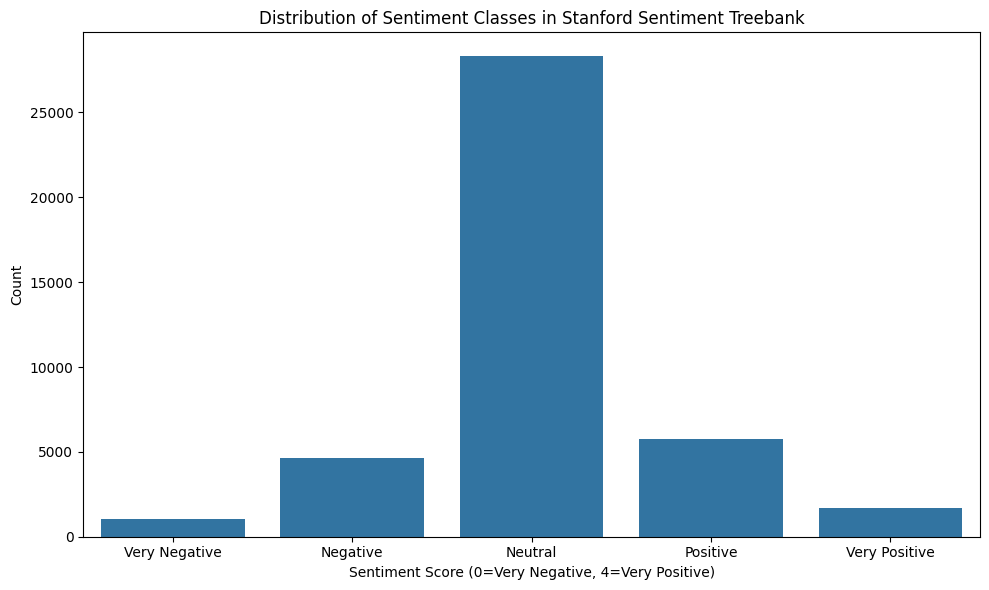

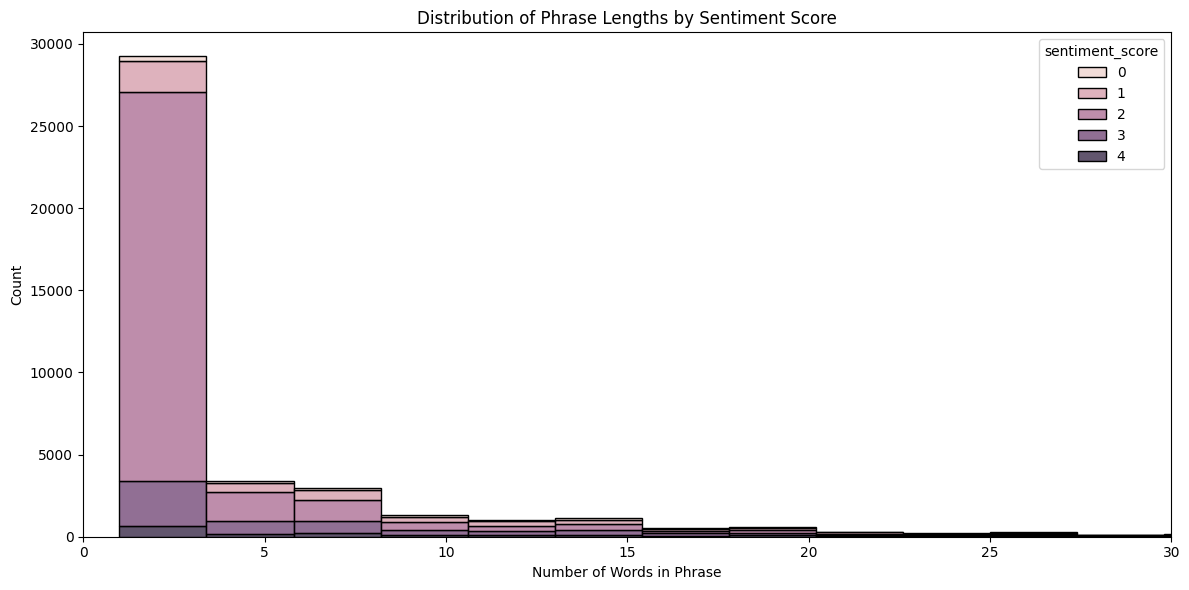


Training set size: 33157 phrases
Test set size: 8290 phrases

Sentiment distribution (%) in training set:
sentiment_score
0     2.581657
1    11.128872
2    68.293271
3    13.948789
4     4.047411
Name: proportion, dtype: float64

Sentiment distribution (%) in test set:
sentiment_score
0     2.581423
1    11.133896
2    68.287093
3    13.944511
4     4.053076
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

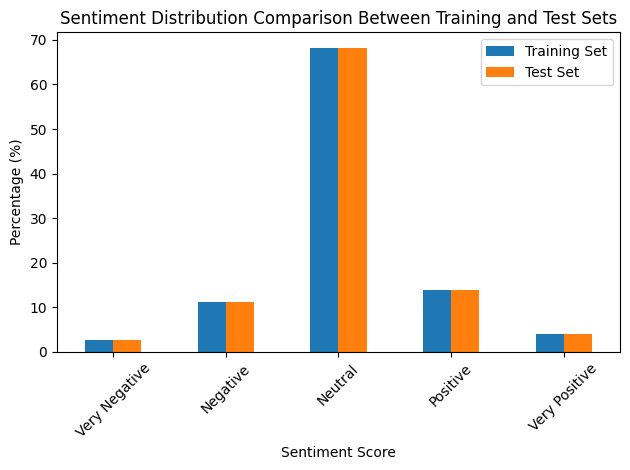

In [3]:
# Train-Test Split for the Stanford Sentiment Treebank Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset if not already loaded
try:
    dev_df
except NameError:
    dev_df = pd.read_csv('./Dataset/parsed_dev_dataset.csv')

# First, let's analyze the dataset characteristics
print(f"Total number of phrases: {len(dev_df)}")
print("\nSentiment distribution:")
sentiment_counts = dev_df['sentiment_score'].value_counts().sort_index()
print(sentiment_counts)

# Visualize the sentiment distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Classes in Stanford Sentiment Treebank')
plt.xlabel('Sentiment Score (0=Very Negative, 4=Very Positive)')
plt.ylabel('Count')
plt.xticks(range(5), ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.tight_layout()
plt.show()

# Analyze phrase length distribution
dev_df['phrase_length'] = dev_df['phrase'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(data=dev_df, x='phrase_length', hue='sentiment_score', bins=20, multiple='stack')
plt.title('Distribution of Phrase Lengths by Sentiment Score')
plt.xlabel('Number of Words in Phrase')
plt.ylabel('Count')
plt.xlim(0, 30)
plt.tight_layout()
plt.show()

# Train-Test Split with Stratification
X = dev_df['phrase']
y = dev_df['sentiment_score']

# Perform stratified split to maintain sentiment distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)} phrases")
print(f"Test set size: {len(X_test)} phrases")

# Verify the split maintains the sentiment distribution
train_sentiment_counts = pd.Series(y_train).value_counts(normalize=True).sort_index() * 100
test_sentiment_counts = pd.Series(y_test).value_counts(normalize=True).sort_index() * 100

print("\nSentiment distribution (%) in training set:")
print(train_sentiment_counts)
print("\nSentiment distribution (%) in test set:")
print(test_sentiment_counts)

# Compare the distributions visually
plt.figure(figsize=(12, 6))
comparison_df = pd.DataFrame({
    'Training Set': train_sentiment_counts,
    'Test Set': test_sentiment_counts
})
comparison_df.plot(kind='bar')
plt.title('Sentiment Distribution Comparison Between Training and Test Sets')
plt.xlabel('Sentiment Score')
plt.ylabel('Percentage (%)')
plt.xticks(range(5), ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Save the split datasets for future use
train_df = pd.DataFrame({'phrase': X_train, 'sentiment_score': y_train}).reset_index(drop=True)
test_df = pd.DataFrame({'phrase': X_test, 'sentiment_score': y_test}).reset_index(drop=True)

train_df.to_csv('./Dataset/sst_train.csv', index=False)
test_df.to_csv('./Dataset/sst_test.csv', index=False)